In [3]:
from __future__ import print_function
import pandas as pd
import numpy as np
np.random.seed(1337)  # for reproducibility
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import get_file
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.datasets import imdb
from keras.utils.np_utils import to_categorical
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
from sklearn.preprocessing import Normalizer
import h5py
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger


In [4]:
path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')

2154496/2144903 [==============================] - 1s 0us/step


In [5]:
df = pd.read_csv(path, header=None)

df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]


print(df.shape)

df.drop_duplicates(keep='first', inplace = True)
df.dropna(inplace=True,axis=1) 


(494021, 42)


In [6]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

encode_numeric_zscore(df, 'duration')
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_text_dummy(df, 'land')
encode_numeric_zscore(df, 'wrong_fragment')
encode_numeric_zscore(df, 'urgent')
encode_numeric_zscore(df, 'hot')
encode_numeric_zscore(df, 'num_failed_logins')
encode_text_dummy(df, 'logged_in')
encode_numeric_zscore(df, 'num_compromised')
encode_numeric_zscore(df, 'root_shell')
encode_numeric_zscore(df, 'su_attempted')
encode_numeric_zscore(df, 'num_root')
encode_numeric_zscore(df, 'num_file_creations')
encode_numeric_zscore(df, 'num_shells')
encode_numeric_zscore(df, 'num_access_files')
encode_numeric_zscore(df, 'num_outbound_cmds')
encode_text_dummy(df, 'is_host_login')
encode_text_dummy(df, 'is_guest_login')
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'serror_rate')
encode_numeric_zscore(df, 'srv_serror_rate')
encode_numeric_zscore(df, 'rerror_rate')
encode_numeric_zscore(df, 'srv_rerror_rate')
encode_numeric_zscore(df, 'same_srv_rate')
encode_numeric_zscore(df, 'diff_srv_rate')
encode_numeric_zscore(df, 'srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')
encode_numeric_zscore(df, 'dst_host_same_srv_rate')
encode_numeric_zscore(df, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_serror_rate')
encode_numeric_zscore(df, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df, 'dst_host_rerror_rate')
encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')


df.dropna(inplace=True,axis=1)
df[0:5]

# Convert to numpy - Classification
x_columns = df.columns.drop('outcome')
x = df[x_columns].values
dummies = pd.get_dummies(df['outcome']) # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
y = dummies.values
df.groupby('outcome')['outcome'].count()

# Create a test/train split.  20% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
X_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

y_train =  np.array(y)

In [7]:
scaler = Normalizer().fit(x)
trainX = scaler.transform(x)
# summarize transformed data
np.set_printoptions(precision=3)
print(trainX[0:5,:])

# scaler = Normalizer().fit(T)
# testT = scaler.transform(T)
# # summarize transformed data
# np.set_printoptions(precision=3)
# #print(testT[0:5,:])

# y_train = np.array(Y)
# y_test = np.array(C)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# X_test = np.reshape(testT, (testT.shape[0], 1, testT.shape[1]))


print(X_train.shape)


batch_size = 32

[[-0.027 -0.001  0.011 -0.021 -0.001 -0.018 -0.005 -0.002 -0.005 -0.002
  -0.003 -0.005 -0.005 -0.013 -0.166 -0.041 -0.161 -0.161 -0.088 -0.088
   0.194 -0.085 -0.097 -0.437 -0.265  0.246 -0.105  0.018 -0.079 -0.162
  -0.161 -0.091 -0.089  0.     0.251  0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.251  0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.251  0.     0.251  0.     0.     0.251  0.251  0.251  0.   ]
 [-0.027 -0.001 -0.01  -0.022 -0.001 -0.018 -0.005 -0.002 -0.005 -0.002
  -0.003 -0.005 -0.005 -0.013 -0.169 -0.042 -0.164 -0.164 -0.089 -0.089
   0.197 -0.086

In [8]:
def create_model() :
  model = Sequential()
  model.add(SimpleRNN(4,input_dim=x_train.shape[1]))
  model.add(Dropout(0.1))
  model.add(Dense(23)) 
  model.add(Activation('sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model

In [9]:
model = create_model()
model.summary()
print(X_train.shape)
print(y_train.shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 4)                 500       
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 23)                115       
                                                                 
 activation (Activation)     (None, 23)                0         
                                                                 
Total params: 615
Trainable params: 615
Non-trainable params: 0
_________________________________________________________________
(145586, 1, 120)
(145586, 23)


In [10]:
cp = callbacks.ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/kddresults/", verbose=1, save_weights_only=True, monitor='val_acc',mode='max')
history = model.fit(X_train,y_train, validation_split=0.2, epochs=500, batch_size=32, callbacks=[cp])

Epoch 1/500
3620/3640 [============================>.] - ETA: 0s - loss: 0.1036 - accuracy: 0.8250
Epoch 1: saving model to /content/drive/My Drive/Colab Notebooks/kddresults/
3640/3640 [==============================] - 9s 2ms/step - loss: 0.1032 - accuracy: 0.8255 - val_loss: 0.0506 - val_accuracy: 0.6433
Epoch 2/500
3635/3640 [============================>.] - ETA: 0s - loss: 0.0228 - accuracy: 0.9216
Epoch 2: saving model to /content/drive/My Drive/Colab Notebooks/kddresults/
3640/3640 [==============================] - 10s 3ms/step - loss: 0.0228 - accuracy: 0.9216 - val_loss: 0.0350 - val_accuracy: 0.7646
Epoch 3/500
3639/3640 [============================>.] - ETA: 0s - loss: 0.0178 - accuracy: 0.9271
Epoch 3: saving model to /content/drive/My Drive/Colab Notebooks/kddresults/
3640/3640 [==============================] - 8s 2ms/step - loss: 0.0178 - accuracy: 0.9271 - val_loss: 0.0307 - val_accuracy: 0.9015
Epoch 4/500
3634/3640 [============================>.] - ETA: 0s - loss:

{'loss': [0.10324940830469131, 0.022839823737740517, 0.017817072570323944, 0.01527315005660057, 0.013192548416554928, 0.01094738207757473, 0.008786930702626705, 0.00770952831953764, 0.007053309120237827, 0.006602625362575054, 0.006278526037931442, 0.006005138158798218, 0.005720040760934353, 0.005488583352416754, 0.0054517388343811035, 0.005220865830779076, 0.005134588107466698, 0.00510714715346694, 0.004927929490804672, 0.0049438574351370335, 0.00485657574608922, 0.004765705671161413, 0.004749131854623556, 0.004717930220067501, 0.004600153304636478, 0.004636706784367561, 0.004642060026526451, 0.0046612415462732315, 0.004540224093943834, 0.004522750619798899, 0.004521540831774473, 0.0045188432559370995, 0.004446995910257101, 0.004420389421284199, 0.00433147419244051, 0.004416256677359343, 0.004478415008634329, 0.004392758011817932, 0.004402638878673315, 0.004372627008706331, 0.004263877868652344, 0.004355707671493292, 0.004430548753589392, 0.004355479963123798, 0.004413156770169735, 0.0

[0.04669738933444023, 0.8958376049995422]

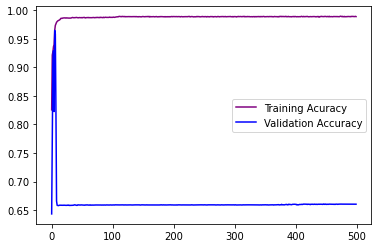

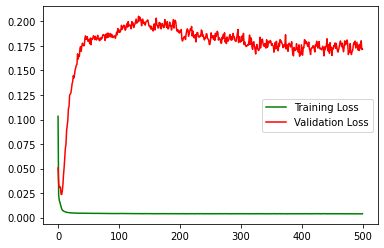

In [12]:
import matplotlib.pylab as plt

print(history.history)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure()
plt.plot(acc,color = 'purple',label = 'Training Acuracy')
plt.plot(val_acc,color = 'blue',label = 'Validation Accuracy')
plt.legend()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss,color = 'green',label = 'Training Loss')
plt.plot(val_loss,color = 'red',label = 'Validation Loss')
plt.legend()

model = create_model()
# Load the model weights that were saved at - "/content/drive/My Drive/Colab Notebooks/reuters/"
model.load_weights("/content/drive/My Drive/Colab Notebooks/kddresults/")
model.evaluate(X_test, y_test)
